# Datawhale 零基础入门数据挖掘-Task3 特征工程

## 特征工程主要目标
对特征进行进一步分析，构造新的特征

常见的特征工程包括：

1. 异常处理：
    * 通过箱线图（或 3-Sigma）分析删除异常值；
    * BOX-COX 转换（处理有偏分布）；
    * 长尾截断；
2. 特征归一化/标准化：
    * 标准化（转换为标准正态分布）；
    * 归一化（抓换到 [0,1] 区间）；
    * 针对幂律分布，可以采用公式：$log(\frac{1+x}{1+median})$
3. 数据分桶：
    * 等频分桶；
    * 等距分桶；
    * Best-KS 分桶（类似利用基尼指数进行二分类）；
    * 卡方分桶；
4. 缺失值处理：
    * 不处理（针对类似 XGBoost 等树模型）；
    * 删除（缺失数据太多）
    * 插值补全，包括均值/中位数/众数/建模预测/多重插补/压缩感知补全/矩阵补全等；
    * 分箱，缺失值一个箱；
5. 特征构造：
    * 构造统计量特征，报告计数、求和、比例、标准差等；
    * 时间特征，包括相对时间和绝对时间，节假日，双休日等；
    * 地理信息，包括分箱，分布编码等方法；
    * 非线性变换，包括 log/ 平方/ 根号等；
    * 特征组合，特征交叉；
6. 特征筛选
    * 过滤式（filter）：先对数据进行特征选择，然后在训练学习器，常见的方法有 Relief/方差选择发/相关系数法/卡方检验法/互信息法；
    * 包裹式（wrapper）：直接把最终将要使用的学习器的性能作为特征子集的评价准则，常见方法有 LVM（Las Vegas Wrapper） ；
    * 嵌入式（embedding）：结合过滤式和包裹式，学习器训练过程中自动进行了特征选择，常见的有 lasso 回归；
7. 降维
    * PCA/ LDA/ ICA；
    * 特征选择也是一种降维。

In [5]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
import xgboost as xgb
import numpy as np
import pandas as pd
from sklearn.metrics import precision_score, recall_score
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error
from lightgbm import LGBMRegressor
from collections import Counter
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
pd.options.display.max_columns = None
warnings.filterwarnings('ignore')

## 2.1 载入数据并简略观察

In [6]:
train_data = pd.read_csv('/Users/benjamin/study/data complete/天池/二手车交易价格预测/data/used_car_train_20200313.csv', sep=' ')
test_data = pd.read_csv('/Users/benjamin/study/data complete/天池/二手车交易价格预测/data/used_car_testA_20200313.csv', sep=' ')
print('训练数据集大小：', train_data.shape)
print('测试数据集大小：', test_data.shape)
train_data.head()

训练数据集大小： (150000, 31)
测试数据集大小： (50000, 30)


,SaleID,name,regDate,model,brand,bodyType,fuelType,gearbox,power,kilometer,notRepairedDamage,regionCode,seller,offerType,creatDate,price,v_0,v_1,v_2,v_3,v_4,v_5,v_6,v_7,v_8,v_9,v_10,v_11,v_12,v_13,v_14
0,0,736,20040402,30.0,6,1.0,0.0,0.0,60,12.5,0.0,1046,0,0,20160404,1850,43.357796,3.966344,0.050257,2.159744,1.143786,0.235676,0.101988,0.129549,0.022816,0.097462,-2.881803,2.804097,-2.420821,0.795292,0.914762
1,1,2262,20030301,40.0,1,2.0,0.0,0.0,0,15.0,-,4366,0,0,20160309,3600,45.305273,5.236112,0.137925,1.380657,-1.422165,0.264777,0.121004,0.135731,0.026597,0.020582,-4.900482,2.096338,-1.030483,-1.722674,0.245522
2,2,14874,20040403,115.0,15,1.0,0.0,0.0,163,12.5,0.0,2806,0,0,20160402,6222,45.978359,4.823792,1.319524,-0.998467,-0.996911,0.251410,0.114912,0.165147,0.062173,0.027075,-4.846749,1.803559,1.565330,-0.832687,-0.229963
3,3,71865,19960908,109.0,10,0.0,0.0,1.0,193,15.0,0.0,434,0,0,20160312,2400,45.687478,4.492574,-0.050616,0.883600,-2.228079,0.274293,0.110300,0.121964,0.033395,0.000000,-4.509599,1.285940,-0.501868,-2.438353,-0.478699
4,4,111080,20120103,110.0,5,1.0,0.0,0.0,68,5.0,0.0,6977,0,0,20160313,5200,44.383511,2.031433,0.572169,-1.571239,2.246088,0.228036,0.073205,0.091880,0.078819,0.121534,-1.896240,0.910783,0.931110,2.834518,1.923482


In [3]:
test_data.head()

,SaleID,name,regDate,model,brand,bodyType,fuelType,gearbox,power,kilometer,notRepairedDamage,regionCode,seller,offerType,creatDate,v_0,v_1,v_2,v_3,v_4,v_5,v_6,v_7,v_8,v_9,v_10,v_11,v_12,v_13,v_14
0,150000,66932,20111212,222.0,4,5.0,1.0,1.0,313,15.0,0.0,1440,0,0,20160329,49.593127,5.246568,1.001130,-4.122264,0.737532,0.264405,0.121800,0.070899,0.106558,0.078867,-7.050969,-0.854626,4.800151,0.620011,-3.664654
1,150001,174960,19990211,19.0,21,0.0,0.0,0.0,75,12.5,1.0,5419,0,0,20160404,42.395926,-3.253950,-1.753754,3.646605,-0.725597,0.261745,0.000000,0.096733,0.013705,0.052383,3.679418,-0.729039,-3.796107,-1.541230,-0.757055
2,150002,5356,20090304,82.0,21,0.0,0.0,0.0,109,7.0,0.0,5045,0,0,20160308,45.841370,4.704178,0.155391,-1.118443,-0.229160,0.260216,0.112081,0.078082,0.062078,0.050540,-4.926690,1.001106,0.826562,0.138226,0.754033
3,150003,50688,20100405,0.0,0,0.0,0.0,1.0,160,7.0,0.0,4023,0,0,20160325,46.440649,4.319155,0.428897,-2.037916,-0.234757,0.260466,0.106727,0.081146,0.075971,0.048268,-4.864637,0.505493,1.870379,0.366038,1.312775
4,150004,161428,19970703,26.0,14,2.0,0.0,0.0,75,15.0,0.0,3103,0,0,20160309,42.184604,-3.166234,-1.572058,2.604143,0.387498,0.250999,0.000000,0.077806,0.028600,0.081709,3.616475,-0.673236,-3.197685,-0.025678,-0.101290


In [47]:
import pandas_profiling
pfr = pandas_profiling.ProfileReport(train_data)
pfr.to_file('./example.html')

### 删除异常值

In [46]:
def outliers_proc(data, col_name, scale=3):
    """
     用于清洗异常值，默认用 box_plot（scale=3）进行清洗
     :param data: 接收 pandas 数据格式
     :param col_name: pandas 列名
     :param scale: 尺度
     :return:
    """
    def box_plot_outliers(data_ser, box_scale):
        """
         利用箱线图去除异常值
         :param data_ser: 接收 pandas.Series 数据格式
         :param box_scale: 箱线图尺度，
         :return:
         """
        iqr = box_scale * (data_ser.quantile(0.75) - data_ser.quantile(0.25))
        val_low = data_ser.quantile(0.25) - iqr
        val_up = data_ser.quantile(0.75) + iqr
        rule_low = (data_ser < val_low)
        rule_up = (data_ser > val_up) 
        return (rule_low, rule_up), (val_low, val_up)
    data_n = data.copy()
    data_series = data_n[col_name]
    rule, value = box_plot_outliers(data_series, box_scale=scale)
    index = np.arange(data_series.shape[0])[rule[0] | rule[1]]
    print("Delete number is: {}".format(len(index)))
    data_n = data_n.drop(index)
    data_n.reset_index(drop=True, inplace=True)
    print("Now column number is: {}".format(data_n.shape[0]))
    index_low = np.arange(data_series.shape[0])[rule[0]]
    outliers = data_series.iloc[index_low]
    print("Description of data less than the lower bound is:")
    print(pd.Series(outliers).describe())
    index_up = np.arange(data_series.shape[0])[rule[1]]
    outliers = data_series.iloc[index_up]
    print("Description of data larger than the upper bound is:")
    print(pd.Series(outliers).describe())
    fig, ax = plt.subplots(1, 2, figsize=(10, 7))
    sns.boxplot(y=data[col_name], data=data, palette="Set1", ax=ax[0])
    sns.boxplot(y=data_n[col_name], data=data_n, palette="Set1", ax=ax[1])
    return data_n

Delete number is: 963
Now column number is: 149037
Description of data less than the lower bound is:
count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: power, dtype: float64
Description of data larger than the upper bound is:
count      963.000000
mean       846.836968
std       1929.418081
min        376.000000
25%        400.000000
50%        436.000000
75%        514.000000
max      19312.000000
Name: power, dtype: float64


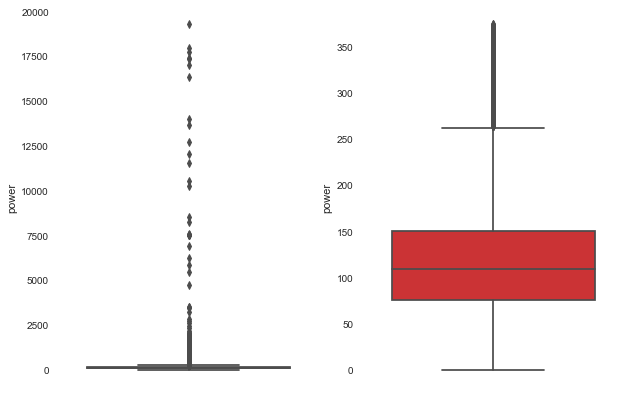

In [49]:
train_data = outliers_proc(train_data, 'power', scale=3)

### 特征构造

In [75]:
# 训练集和测试集放在一起，方便构造特征
train_data['train'] = 1
test_data['train'] = 0
data = pd.concat([train_data, test_data], ignore_index=True, sort=False)

In [76]:
# createDate是二手汽车广告发布时间，regDate是汽车发布时间，两者之差反应了汽车使用时间，汽车使用时间与价格是成反比的
data['used_time'] = (pd.to_datetime(data['creatDate'], format='%Y%m%d', errors='coerce')-
                    pd.to_datetime(data['regDate'], format='%Y%m%d', errors='coerce')).dt.days

In [77]:
data['used_time'].isnull().sum()

15072

发现有15k左右的样本时间是有问题的。
这部分数据可以删除也可以保留。15k的样本数量比较多，不建议删除
如果是用决策树之类的算法，可以处理缺失值，可以不用管。

In [78]:
## 观察下缺失值
data[data['used_time'].isnull()][['regDate', 'creatDate']]

,regDate,creatDate
14,20070009,20160402
20,19970004,20160311
22,19970008,20160326
42,19960009,20160328
51,20020006,20160325
...,...,...
198991,20000001,20160325
198996,20010001,20160322
199007,20030003,20160401
199021,20080004,20160318


**发现缺失值主要是汽车注册时间有点问题，月份都是00，后续可以考虑把这部分月份值设为1月或者其他月份，看看效果。**

In [79]:
## 从邮编中提取城市信息，这是利用先验知识进行特征构造
data['city'] = data['regionCode'].apply(lambda x: str(x)[:-3])

In [80]:
data.head()

,SaleID,name,regDate,model,brand,bodyType,fuelType,gearbox,power,kilometer,notRepairedDamage,regionCode,creatDate,price,v_0,v_1,v_2,v_3,v_4,v_5,v_6,v_7,v_8,v_9,v_10,v_11,v_12,v_13,v_14,train,used_time,city
0,0,736,20040402,30.0,6,1.0,0.0,0.0,60,12.5,0.0,1046,20160404,1850.0,43.357796,3.966344,0.050257,2.159744,1.143786,0.235676,0.101988,0.129549,0.022816,0.097462,-2.881803,2.804097,-2.420821,0.795292,0.914762,1,4385.0,1
1,1,2262,20030301,40.0,1,2.0,0.0,0.0,0,15.0,NaN,4366,20160309,3600.0,45.305273,5.236112,0.137925,1.380657,-1.422165,0.264777,0.121004,0.135731,0.026597,0.020582,-4.900482,2.096338,-1.030483,-1.722674,0.245522,1,4757.0,4
2,2,14874,20040403,115.0,15,1.0,0.0,0.0,163,12.5,0.0,2806,20160402,6222.0,45.978359,4.823792,1.319524,-0.998467,-0.996911,0.251410,0.114912,0.165147,0.062173,0.027075,-4.846749,1.803559,1.565330,-0.832687,-0.229963,1,4382.0,2
3,3,71865,19960908,109.0,10,0.0,0.0,1.0,193,15.0,0.0,434,20160312,2400.0,45.687478,4.492574,-0.050616,0.883600,-2.228079,0.274293,0.110300,0.121964,0.033395,0.000000,-4.509599,1.285940,-0.501868,-2.438353,-0.478699,1,7125.0,
4,4,111080,20120103,110.0,5,1.0,0.0,0.0,68,5.0,0.0,6977,20160313,5200.0,44.383511,2.031433,0.572169,-1.571239,2.246088,0.228036,0.073205,0.091880,0.078819,0.121534,-1.896240,0.910783,0.931110,2.834518,1.923482,1,1531.0,6


In [103]:
# 计算某品牌的销售统计量，同学们还可以计算其他特征的统计量
# 这里要以 train 的数据计算统计量
def gene_statics_features(data, column_name, statics_column_name, statics):
    return data.groupby(column_name)[statics_column_name].transform(statics)
statics = ['count', 'max', 'median', 'min', 'sum', 'std', 'mean']
for i, sta in enumerate(statics):
    if i == 0:
        data['brand_brand_' + sta] = gene_statics_features(data, 'brand', 'brand', sta)
    else:
        data['brand_price_' + sta] = gene_statics_features(data, 'brand', 'price', sta)
data.head()

,SaleID,name,regDate,model,brand,bodyType,fuelType,gearbox,power,kilometer,notRepairedDamage,regionCode,creatDate,price,v_0,v_1,v_2,v_3,v_4,v_5,v_6,v_7,v_8,v_9,v_10,v_11,v_12,v_13,v_14,train,used_time,city,brand_brand_count,brand_price_max,brand_price_median,brand_price_min,brand_price_sum,brand_price_std,brand_price_mean
0,0,736,20040402,30.0,6,1.0,0.0,0.0,60,12.5,0.0,1046,20160404,1850.0,43.357796,3.966344,0.050257,2.159744,1.143786,0.235676,0.101988,0.129549,0.022816,0.097462,-2.881803,2.804097,-2.420821,0.795292,0.914762,1,4385.0,1,13695,35990.0,1800.0,13.0,36457518.0,4562.233331,3576.721083
1,1,2262,20030301,40.0,1,2.0,0.0,0.0,0,15.0,NaN,4366,20160309,3600.0,45.305273,5.236112,0.137925,1.380657,-1.422165,0.264777,0.121004,0.135731,0.026597,0.020582,-4.900482,2.096338,-1.030483,-1.722674,0.245522,1,4757.0,4,18188,84000.0,6399.0,15.0,124044603.0,8988.865406,9083.523946
2,2,14874,20040403,115.0,15,1.0,0.0,0.0,163,12.5,0.0,2806,20160402,6222.0,45.978359,4.823792,1.319524,-0.998467,-0.996911,0.251410,0.114912,0.165147,0.062173,0.027075,-4.846749,1.803559,1.565330,-0.832687,-0.229963,1,4382.0,2,1969,45000.0,8500.0,100.0,14373814.0,5425.058140,9858.582990
3,3,71865,19960908,109.0,10,0.0,0.0,1.0,193,15.0,0.0,434,20160312,2400.0,45.687478,4.492574,-0.050616,0.883600,-2.228079,0.274293,0.110300,0.121964,0.033395,0.000000,-4.509599,1.285940,-0.501868,-2.438353,-0.478699,1,7125.0,,18760,92900.0,5200.0,15.0,113034210.0,8244.695287,8077.333857
4,4,111080,20120103,110.0,5,1.0,0.0,0.0,68,5.0,0.0,6977,20160313,5200.0,44.383511,2.031433,0.572169,-1.571239,2.246088,0.228036,0.073205,0.091880,0.078819,0.121534,-1.896240,0.910783,0.931110,2.834518,1.923482,1,1531.0,6,6231,31500.0,2300.0,20.0,15414322.0,3344.689763,3306.375375


In [104]:
# 数据分桶 以 power 为例
# 这时候我们的缺失值也进桶了，
# 为什么要做数据分桶呢，原因有很多，= =
# 1. 离散后稀疏向量内积乘法运算速度更快，计算结果也方便存储，容易扩展；
# 2. 离散后的特征对异常值更具鲁棒性，如 age>30 为 1 否则为 0，对于年龄为 200 的也不会对模型造成很大的干扰；
# 3. LR 属于广义线性模型，表达能力有限，经过离散化后，每个变量有单独的权重，这相当于引入了非线性，能够提升模型的表达能力，加大拟合；
# 4. 离散后特征可以进行特征交叉，提升表达能力，由 M+N 个变量编程 M*N 个变量，进一步引入非线形，提升了表达能力；
# 5. 特征离散后模型更稳定，如用户年龄区间，不会因为用户年龄长了一岁就变化

# 当然还有很多原因，LightGBM 在改进 XGBoost 时就增加了数据分桶，增强了模型的泛化性

bin = [i*10 for i in range(31)]
data['power_bin'] = pd.cut(data['power'], bin, labels=False)
data[['power_bin', 'power']].head()

,power_bin,power
0,5.0,60
1,NaN,0
2,16.0,163
3,19.0,193
4,6.0,68


In [105]:
# 删除不需要的数据
data = data.drop(['creatDate', 'regDate', 'regionCode'], axis=1)

In [112]:
# 这部分数据可以用作树模型训练使用，导出保存
data.to_csv('data_for_tree.csv', index=False)

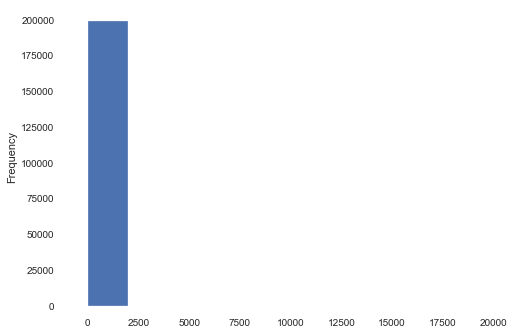

In [115]:
### 构造LR, NN之类模型使用的特征
## 看下数据分布：
data['power'].plot.hist()

## 不做特征工程使用lightgbm进行训练，看测试效果

In [41]:
columns = train_data.columns
feature_columns = columns.tolist()
feature_columns.remove('price')
label_column = 'price'
features = train_data[feature_columns]
labels = train_data[['price']]
train_x, test_x, train_y, test_y = train_test_split(features, labels, test_size=0.3)
lgb_model.fit(train_x, train_y, eval_metric='l2', eval_set=[(test_x, test_y)])

In [42]:
xgb_model = XGBRegressor()
lgb_model = LGBMRegressor()

In [56]:
xgb_model.fit(train_x, train_y)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)

In [57]:
predict_lgb = lgb_model.predict(test_x)
predict_xgb = xgb_model.predict(test_x)

In [58]:
print('lgb: ',str(mean_absolute_error(test_y, predict_lgb)))
print('xgb', str(mean_absolute_error(test_y, predict_xgb)))

lgb:  702.2411014972247
xgb 868.4935407146666


### 进行特征工程后的模型效果

In [108]:
from sklearn.preprocessing import LabelEncoder

In [109]:
lbl = LabelEncoder()
data['city'] = lbl.fit_transform(data['city'].astype(str))

In [110]:
columns = data.columns
feature_columns = columns.tolist()
feature_columns.remove('price')
label_column = 'price'
features = data[data['train']==1][feature_columns]
labels = train_data[['price']]
train_x, test_x, train_y, test_y = train_test_split(features, labels, test_size=0.3)
lgb_model.fit(train_x, train_y, eval_metric='l2', eval_set=[(test_x, test_y)])

<class 'list'>
[1]	valid_0's l2: 3.95266e+07
<class 'list'>
[2]	valid_0's l2: 3.29327e+07
<class 'list'>
[3]	valid_0's l2: 2.75291e+07
<class 'list'>
[4]	valid_0's l2: 2.3121e+07
<class 'list'>
[5]	valid_0's l2: 1.95288e+07
<class 'list'>
[6]	valid_0's l2: 1.65676e+07
<class 'list'>
[7]	valid_0's l2: 1.41651e+07
<class 'list'>
[8]	valid_0's l2: 1.21746e+07
<class 'list'>
[9]	valid_0's l2: 1.05405e+07
<class 'list'>
[10]	valid_0's l2: 9.23137e+06
<class 'list'>
[11]	valid_0's l2: 8.1056e+06
<class 'list'>
[12]	valid_0's l2: 7.16539e+06
<class 'list'>
[13]	valid_0's l2: 6.38369e+06
<class 'list'>
[14]	valid_0's l2: 5.73926e+06
<class 'list'>
[15]	valid_0's l2: 5.18025e+06
<class 'list'>
[16]	valid_0's l2: 4.71596e+06
<class 'list'>
[17]	valid_0's l2: 4.33732e+06
<class 'list'>
[18]	valid_0's l2: 4.00664e+06
<class 'list'>
[19]	valid_0's l2: 3.73148e+06
<class 'list'>
[20]	valid_0's l2: 3.49478e+06
<class 'list'>
[21]	valid_0's l2: 3.29689e+06
<class 'list'>
[22]	valid_0's l2: 3.12066e+06

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [111]:
predict_lgb = lgb_model.predict(test_x)
print('lgb: ',str(mean_absolute_error(test_y, predict_lgb)))

lgb:  670.7592588195453


**相比于之前的700，做了特征处理后的MAE降到了670**